In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vp = np.load('/content/Marmousi_cropped.npy')

In [22]:
nx = vp.shape[1] # number of grid points in the horizontal direction
nz = vp.shape[0] # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 2000 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 900 # source horizontal location in meters
srcz = 800 # source vertical location in meters

nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

# vp = np.arange(2000,4500,(4500-2000)/nz)
# vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model

#vp = np.ones((nx,nz))*3000.0

time = np.arange(0,nt*dt,dt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
wav  = (1.0-2.0*np.power(np.pi*f0*(time-t0),2))*np.exp(-np.power(np.pi*f0*(time-t0),2)) # computing the wavelet

In [11]:
assert dt < dd/(np.sqrt(2.0)*np.max(vp)),'Courant not satisfied!' # making sure Courant number is fine

In [12]:
def gen_absorb(nx,nz,nabs,a,FreeSurf=False):
    absorb = np.ones((nx,nz))
    abs_coefs = np.zeros(nabs)
    abs_coefs = np.exp(-(a**2 * (nabs-np.arange(nabs))**2))
    absorb[:nabs,:] = absorb[:nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-nabs:,:] = absorb[-nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-nabs:] = absorb[:,-nabs:]*abs_coefs[::-1]
    if(FreeSurf==False):
        absorb[:,:nabs] = absorb[:,:nabs]*abs_coefs
    return absorb

In [13]:
def comp_deriv(p,dd):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(dd**2)
    return pdx2, pdz2

In [14]:
def fd_ac(vp,dd,dt,srcx,srcz,wav,nabs=40,a=0.0053,FreeSurf=False):
    srci = int(srcx/dd) # find where source is located on the grid
    srcj = int(srcz/dd)
    nx,nz = vp.shape # infer shapes
    nt = wav.shape[0]

    field2d = np.zeros((nx,nz,nt),dtype=np.float32) # define variables  - field2d is output wavefield
    p = np.zeros((nx,nz),dtype=np.float32) # these are pressures at current, prev and next steps
    ppast = np.zeros((nx,nz),dtype=np.float32)
    pfut = np.zeros((nx,nz),dtype=np.float32)
    
    vp2 = vp**2 # square of velocity for easier computation
    absorb = gen_absorb(nx,nz,nabs,a,FreeSurf=FreeSurf) # generate absorbing mask
    
    for i in range(nt): # main loop
        pdx2, pdz2 = comp_deriv(p,dd) # compute pressure derivatives
        pfut = 2 * p + vp2 * dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 
        pfut[srci,srcj] = pfut[srci,srcj] + wav[i] / (dd * dd) * dt ** 2 # inject source term at selected point
        
        p *= absorb # apply absorbing mask
        pfut *= absorb # apply absorbing mask

        field2d[:,:,i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut
    return field2d

In [23]:
# %%timeit
wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf) # example computation

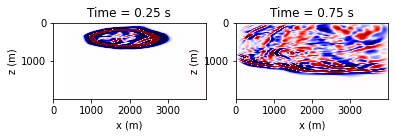

In [24]:
it1 = 500
it2 = 1500

scal=1e-8
x = np.arange(0,nx*dd,dd)
z = np.arange(0,nz*dd,dd)

ext = [x[0],x[-1],z[-1],z[0]]

fig,ax = plt.subplots(1,2)
ax[0].imshow(10*np.squeeze(wvfld[:,:,it1]).T,cmap='seismic',vmax=scal,vmin=-scal,extent=ext)
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('z (m)')
ax[0].set_title('Time = '+str(time[it1])+' s')
ax[1].imshow(10*np.squeeze(wvfld[:,:,it2]).T,cmap='seismic',vmax=scal,vmin=-scal,extent=ext)
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('z (m)')
ax[1].set_title('Time = '+str(time[it2])+' s')

plt.show()